# Preliminary Results

## Load Libraries

In [1]:
## code to get rid of warnings
defaultW <- getOption("warn") 
options(warn = -1) 
##
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(kableExtra)
library(knitr)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




## Data Intake and Pre-Processing

First, we will read in the dataset. The code here assumes you've downloaded the dataset and placed them into a data folder. If you would like to run our code and follow along, please clone our GitHub repository [here](https://github.com/KevinSaigon/stat-201-project)

In [2]:
data <- read.csv(file = "data/athlete_events.csv")
# website says "Demonstrate that the dataset can be read from the web into R." - is local files okay? Ask on Monday

We will then do some pre-processing to get rid of any athlete whose age is is not known as well as filter out ones who did not win gold medals. 

The next step was then to only count first-time wins for multiple-time medal winners (i.e Michael Phelps). The code below essentially only keep the first occurrence of an athlete's ID, and since we sorted the dataframe by Year, this equates to the athlete's first time winning the gold medal.

In [3]:
processed_df <- data[order(data$Year),]  %>% 
    filter(!is.na(Age)) %>% # get rid of NA/Age
    filter(!is.na(Medal)) # we should get rid of anyone who didn't win a medal either - does NA in the medal mean they didn't win or they don't know
                            # also, let's decide if we care about bronze/silver as opposed to just looking at gold
#     filter(Medal == "Gold")

first_time_only <- processed_df[match(unique(processed_df$ID), processed_df$ID),] # only first time winners now, if they won a second time, it was excluded
    
head(first_time_only)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,12068,Arthur Charles Blake,M,24,NA,NA,United States,USA,1896 Summer,1896,Summer,Athina,Athletics,"Athletics Men's 1,500 metres",Silver
2,12563,Conrad Helmut Fritz Bcker,M,25,NA,NA,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,"Gymnastics Men's Parallel Bars, Teams",Gold
4,12929,John Mary Pius Boland,M,25,NA,NA,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,Gold
6,16616,"Thomas Edmund ""Tom"" Burke",M,21,183,66,United States,USA,1896 Summer,1896,Summer,Athina,Athletics,Athletics Men's 100 metres,Gold
8,17492,Eugne Henri Callot,M,20,NA,NA,France,FRA,1896 Summer,1896,Summer,Athina,Fencing,"Fencing Men's Foil, Individual",Silver
9,18785,Demetrius Emmanuel Casdagli,M,23,NA,NA,Greece,GRE,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,Silver


Next, we will split the dataset by their Season, the winter Olympics vs the summer Olympics

In [4]:
winter_df <- first_time_only %>% 
    filter(Season == "Winter")

summer_df <- first_time_only %>% 
    filter(Season == "Summer")

head(winter_df)
head(summer_df)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,391,Clarence John Abel,M,23,185,102,United States,USA,1924 Winter,1924,Winter,Chamonix,Ice Hockey,Ice Hockey Men's Ice Hockey,Silver
2,1341,Johan Petter hln (Andersson-),M,44,NA,NA,Sweden,SWE,1924 Winter,1924,Winter,Chamonix,Curling,Curling Men's Curling,Silver
3,3872,William Harding Anderson,M,22,NA,NA,Great Britain,GBR,1924 Winter,1924,Winter,Chamonix,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze
4,4060,Georges Jules Andr,M,47,NA,NA,France,FRA,1924 Winter,1924,Winter,Chamonix,Curling,Curling Men's Curling,Bronze
5,5232,Thomas Alfred Arnold,M,22,NA,NA,Great Britain-1,GBR,1924 Winter,1924,Winter,Chamonix,Bobsleigh,Bobsleigh Men's Four/Five,Silver
6,5932,Alfred Aufdenblatten,M,26,NA,NA,Switzerland,SUI,1924 Winter,1924,Winter,Chamonix,Military Ski Patrol,Military Ski Patrol Men's Military Ski Patrol,Gold


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,12068,Arthur Charles Blake,M,24,NA,NA,United States,USA,1896 Summer,1896,Summer,Athina,Athletics,"Athletics Men's 1,500 metres",Silver
2,12563,Conrad Helmut Fritz Bcker,M,25,NA,NA,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,"Gymnastics Men's Parallel Bars, Teams",Gold
3,12929,John Mary Pius Boland,M,25,NA,NA,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,Gold
4,16616,"Thomas Edmund ""Tom"" Burke",M,21,183,66,United States,USA,1896 Summer,1896,Summer,Athina,Athletics,Athletics Men's 100 metres,Gold
5,17492,Eugne Henri Callot,M,20,NA,NA,France,FRA,1896 Summer,1896,Summer,Athina,Fencing,"Fencing Men's Foil, Individual",Silver
6,18785,Demetrius Emmanuel Casdagli,M,23,NA,NA,Greece,GRE,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,Silver


In [5]:
nrow(winter_df)

[1] 3658

## Calculations 

If we are assuming that this dataset is 100% accurate and thus represent that entire population of all Olympic participants, then we could consider the dataset a population, and thus uncertainty would be 0%. However, in reality, if we were trying to gather this dataset ourselves, it is extremely unlikely as well as unfeasible to collect so many data points. Realistically, we would take a sample of this population, so we will will take an initial sample of 3000

In [6]:
winter_sample <- winter_df %>% 
    rep_sample_n(size = 1000, reps = 1) %>% 
    subset(select = -(replicate))

summer_sample <- summer_df %>% 
    rep_sample_n(size = 1000, reps = 1) %>% 
    subset(select = -(replicate))

head(winter_sample)

ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
50914,Martti Elias Huhtala,M,29,175,64,Finland,FIN,1948 Winter,1948,Winter,Sankt Moritz,Nordic Combined,Nordic Combined Men's Individual,Silver
49564,Ylva Erika Holst,F,22,179,82,Sweden,SWE,2002 Winter,2002,Winter,Salt Lake City,Ice Hockey,Ice Hockey Women's Ice Hockey,Bronze
55307,Erik Stein Johnsen,M,22,NA,NA,Norway,NOR,1988 Winter,1988,Winter,Calgary,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",Silver
2639,Hans Daniel Alfredsson,M,33,182,92,Sweden,SWE,2006 Winter,2006,Winter,Torino,Ice Hockey,Ice Hockey Men's Ice Hockey,Gold
102411,Mikko Tapani Ronkainen,M,27,166,64,Finland,FIN,2006 Winter,2006,Winter,Torino,Freestyle Skiing,Freestyle Skiing Men's Moguls,Silver
13698,Jan Bos,M,22,190,83,Netherlands,NED,1998 Winter,1998,Winter,Nagano,Speed Skating,"Speed Skating Men's 1,000 metres",Silver


From this, we can calculate our estimates of the mean for each season

In [7]:
winter_mean_estimate <- mean(winter_sample$Age)
summer_mean_estimate <- mean(summer_sample$Age)

print(paste("Winter Mean Estimate:", winter_mean_estimate))
print(paste("Summer Mean Estimate:", summer_mean_estimate))

[1] "Winter Mean Estimate: 25.153"
[1] "Summer Mean Estimate: 25.274"


## Sampling

Then, we'll perform bootstrapping or resampling without replacement to calculate uncertainty later on

In [8]:
winter_bootstrap <- winter_sample %>% 
    rep_sample_n(size = 1000, reps = 200, replace = TRUE)

summer_bootstrap <- summer_sample %>% 
    rep_sample_n(size = 1000, reps = 200, replace = TRUE)


head(summer_bootstrap)

replicate,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,86494,Shuhei Nishida,M,22,176,61,Japan,JPN,1932 Summer,1932,Summer,Los Angeles,Athletics,Athletics Men's Pole Vault,Silver
1,60628,Moses Kipkore Kiptanui,M,24,175,60,Kenya,KEN,1996 Summer,1996,Summer,Atlanta,Athletics,"Athletics Men's 3,000 metres Steeplechase",Silver
1,128892,Kazuo Watanabe,M,22,168,66,Japan,JPN,1960 Summer,1960,Summer,Roma,Swimming,Swimming Men's 4 x 100 metres Medley Relay,Bronze
1,47740,Frank Sherman Henry,M,38,NA,NA,United States,USA,1948 Summer,1948,Summer,London,Equestrianism,"Equestrianism Men's Dressage, Team",Silver
1,70827,Jorge Llopart Ribas,M,28,167,63,Spain,ESP,1980 Summer,1980,Summer,Moskva,Athletics,Athletics Men's 50 kilometres Walk,Silver
1,120510,Yelizaveta Ivanovna Tishchenko,F,25,190,76,Russia,RUS,2000 Summer,2000,Summer,Sydney,Volleyball,Volleyball Women's Volleyball,Silver


Now, we will calculate the sample mean for each sample.

In [9]:
winter_resampled_means <- winter_bootstrap %>% 
    group_by(replicate) %>% 
    summarize(mean_age = mean(Age))

summer_resampled_means <- summer_bootstrap %>% 
    group_by(replicate) %>% 
    summarize(mean_age = mean(Age))

head(winter_resampled_means)
head(summer_resampled_means)

replicate,mean_age
<int>,<dbl>
1,25.172
2,25.098
3,25.222
4,25.090
5,25.058
6,25.305


replicate,mean_age
<int>,<dbl>
1,25.179
2,24.908
3,25.383
4,25.392
5,25.208
6,25.474


## Visualizations

Let's first remind ourselves of our calculated estimates

In [10]:
name <- c("Winter Mean Estimate", "Summer Mean Estimate")
values <- c(winter_mean_estimate, summer_mean_estimate)

tab <- data.frame(name, values)
tab

name,values
<chr>,<dbl>
Winter Mean Estimate,25.153
Summer Mean Estimate,25.274


In [11]:
# function to plot histogram with a vertical line indicating the mean, 
# with or without the Gaussian curve
# @params: 
#     df: a dataframe
#     col: column name (string)
#     bin_width: int
#     is_bellcurve: whether you want the bell curve option or not (bool),
#                   default is FALSE
# @return: a plot object so that you can customize the title and axis with labs()

plot_histogram <- function(df, col, bin_width, is_bellcurve) {
    plot <- df %>%
        ggplot(aes(x=pull(df, col))) +
        geom_vline(xintercept = mean(pull(df, col), color="blue")) +
        geom_text(aes(x = mean(pull(df, col)), 
                      y=0,
                      label=mean(pull(df, col)),
                      hjust=0,
                      vjust=1),
                  color="blue") +
        xlab(col)
        
    if (missing(is_bellcurve) || (is_bellcurve == FALSE)) {
        plot <- plot + 
        geom_histogram(binwidth=bin_width, color="white", alpha=0.5) +
        ylab("Count") +
        ggtitle(paste0("Distribution of ", col))
    } else {
        plot <- plot +
        geom_histogram(aes(y=..density..), binwidth=bin_width, color="white", alpha=0.5) +
        stat_function(fun=dnorm, color="red", args=list(mean=mean(pull(df, col)), 
                                                        sd=sd(pull(df, col)))) +
        ylab("Probability density") +
        ggtitle(paste0("Distribution of ", col))
    }
    
    return (plot)
}

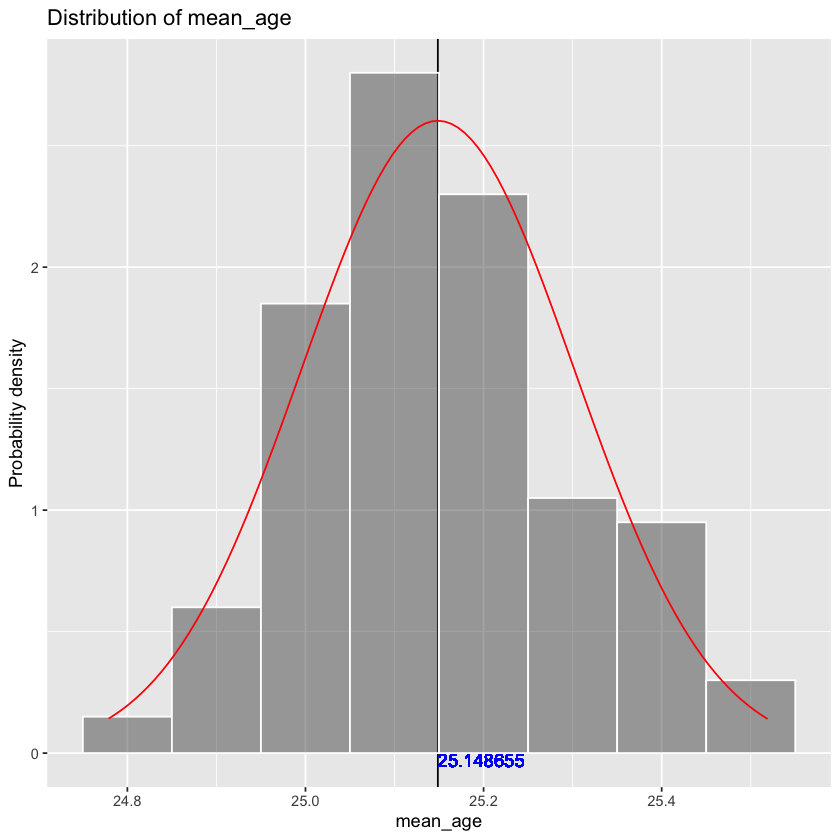

In [16]:
plot_histogram(winter_resampled_means, "mean_age", 0.1, TRUE)

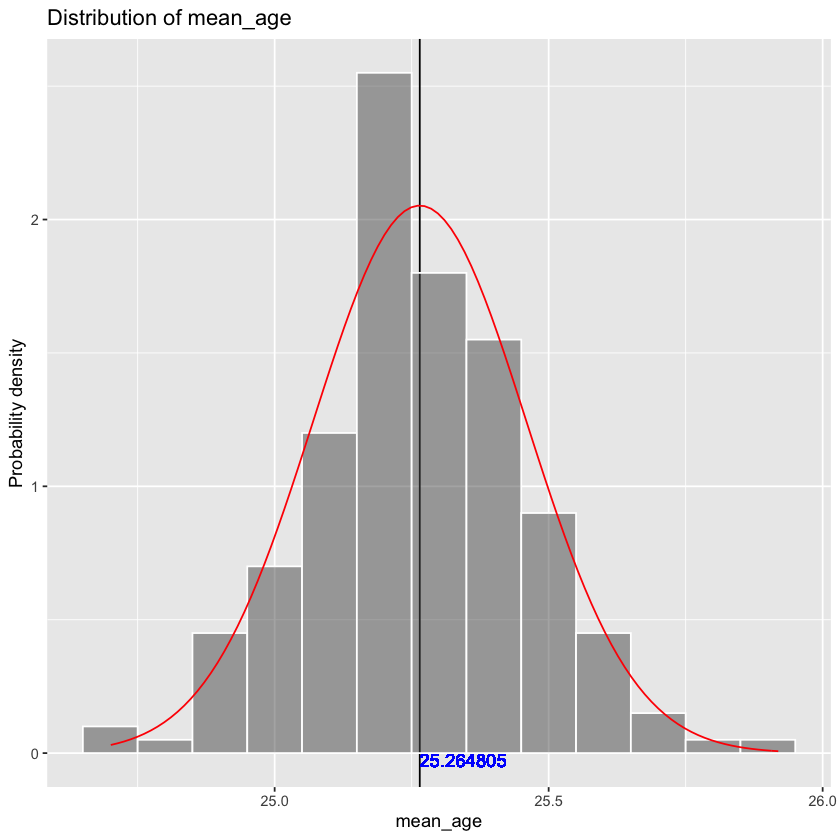

In [17]:
plot_histogram(summer_resampled_means, "mean_age", 0.1, TRUE)